In [2]:
import torch
import util
from model import handpose_model
import numpy as np
import cv2
import util
import math
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib
from torchvision import transforms

In [3]:
model = handpose_model()

model_dict = torch.load('model/hand_pose_model.pth')

model.load_state_dict(util.transfer(model, model_dict))

test_image = 'images/hand.jpg'
oriImg = cv2.imread(test_image)  # B,G,R order

scale_search = [0.5, 1.0, 1.5, 2.0]
# scale_search = [0.5]
boxsize = 368
stride = 8
padValue = 128
thre1 = 0.1
thre2 = 0.05
multiplier = [x * boxsize / oriImg.shape[0] for x in scale_search]
heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 22))
# paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))

for m in range(len(multiplier)):
    scale = multiplier[m]
    imageToTest = cv2.resize(oriImg, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    imageToTest_padded, pad = util.padRightDownCorner(imageToTest, stride, padValue)
    im = np.transpose(np.float32(imageToTest_padded[:, :, :, np.newaxis]), (3, 2, 0, 1)) / 256 - 0.5
    im = np.ascontiguousarray(im)

    data = torch.from_numpy(im).float()
    if torch.cuda.is_available():
        data = data.cuda()
    # data = data.permute([2, 0, 1]).unsqueeze(0).float()
    with torch.no_grad():
        output = model(data).numpy()

    # extract outputs, resize, and remove padding
    heatmap = np.transpose(np.squeeze(output), (1, 2, 0))  # output 1 is heatmaps
    heatmap = cv2.resize(heatmap, (0, 0), fx=stride, fy=stride, interpolation=cv2.INTER_CUBIC)
    heatmap = heatmap[:imageToTest_padded.shape[0] - pad[2], :imageToTest_padded.shape[1] - pad[3], :]
    heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

    heatmap_avg += heatmap / len(multiplier)

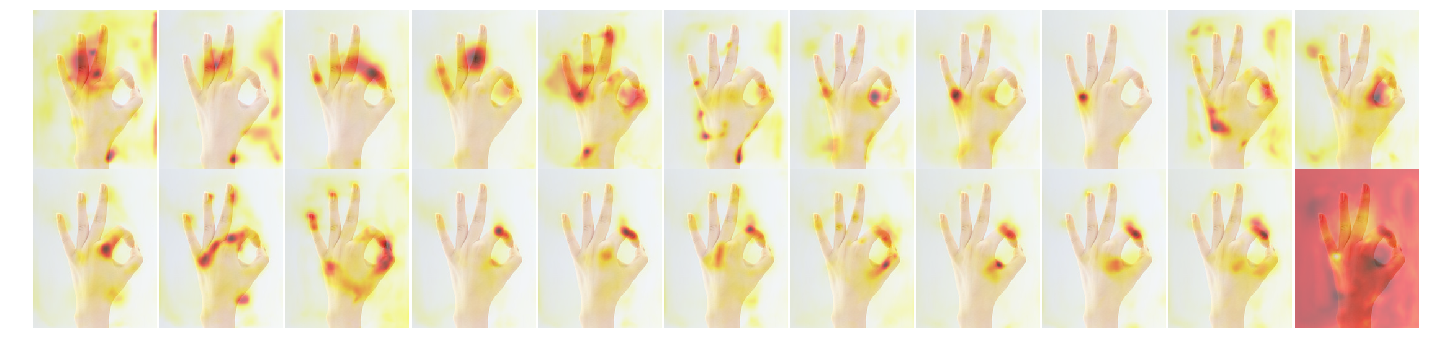

In [4]:
f, axarr = plt.subplots(2, 11)
f.set_size_inches((20, 5))
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(22):
    ax = axarr[i//11, i%11]
    ax.imshow(oriImg[:, :, [2, 1, 0]])
    ax.imshow(heatmap_avg[:, :, i], alpha=.5, cmap=plt.cm.hot_r)
    ax.axis('off')

In [1]:
# f1, axarr1 = plt.subplots(2, 11)
# f1.set_size_inches((20, 5))
# plt.tight_layout()
# plt.subplots_adjust(wspace=0, hspace=0)
    
all_peaks = []
peak_counter = 0
for part in range(21):
    map_ori = heatmap_avg[:, :, part]
    one_heatmap = gaussian_filter(map_ori, sigma=3)

    map_left = np.zeros(one_heatmap.shape)
    map_left[1:, :] = one_heatmap[:-1, :]
    map_right = np.zeros(one_heatmap.shape)
    map_right[:-1, :] = one_heatmap[1:, :]
    map_up = np.zeros(one_heatmap.shape)
    map_up[:, 1:] = one_heatmap[:, :-1]
    map_down = np.zeros(one_heatmap.shape)
    map_down[:, :-1] = one_heatmap[:, 1:]

    peaks_binary = np.logical_and.reduce(
        (one_heatmap >= map_left, one_heatmap >= map_right, one_heatmap >= map_up, one_heatmap >= map_down,
         one_heatmap > 0.01))
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
    peaks_with_score = [x + (map_ori[x[1], x[0]],) for x in peaks]
    peak_id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (peak_id[i],) for i in range(len(peak_id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)
# print(one_heatmap.min())
# print(one_heatmap.max())
# plt.subplot(1, 3, 1)
# plt.imshow(oriImg[:, :, [2, 1, 0]])
# plt.imshow(one_heatmap, alpha=.5, cmap=plt.cm.hot_r)
# plt.subplot(1, 3, 2)
# plt.imshow(oriImg[:, :, [2, 1, 0]])
# plt.imshow(peaks_binary.astype(int), alpha=.5, cmap=plt.cm.hot_r)
# plt.subplot(1, 3, 3)
# plt.imshow(peaks_binary.astype(int))

NameError: name 'heatmap_avg' is not defined

In [41]:
all_peaks

[[(0, 0, 0.005758589395554736, 0),
  (91, 19, 0.011657688184641302, 1),
  (88, 24, 0.011693946667946875, 2),
  (129, 24, 0.012609299388714135, 3),
  (199, 24, 0.031458578538149595, 4),
  (87, 25, 0.011807503993622959, 5),
  (106, 46, 0.022161464672535658, 6),
  (126, 52, 0.011226662318222225, 7),
  (165, 55, 0.014599947317037731, 8),
  (0, 64, 0.007276388991158456, 9),
  (95, 69, 0.03953805781202391, 10),
  (76, 81, 0.03742737416177988, 11),
  (182, 90, 0.014585475029889494, 12),
  (24, 97, 0.010303108138032258, 13),
  (23, 98, 0.01035579014569521, 14),
  (0, 103, 0.005246888875262812, 15),
  (102, 103, 0.041524328175000846, 16),
  (95, 124, 0.022181512758834288, 17),
  (23, 132, 0.008339021340361796, 18),
  (21, 163, 0.011154657579027116, 19),
  (0, 166, 0.00874298921553418, 20),
  (118, 166, 0.006452146757510491, 21),
  (164, 169, 0.016618835739791393, 22),
  (66, 181, 0.013404360797721893, 23),
  (138, 193, 0.012456805328838527, 24),
  (137, 194, 0.012025476025883108, 25),
  (199, 1

In [42]:
np.nonzero(peaks_binary)

(array([ 29,  39,  89,  91,  92, 105, 158, 162, 217, 256]),
 array([110,  74,  39, 143, 144, 155, 111, 151, 141, 149]))

In [43]:
peaks

[(110, 29),
 (74, 39),
 (39, 89),
 (143, 91),
 (144, 92),
 (155, 105),
 (111, 158),
 (151, 162),
 (141, 217),
 (149, 256)]